In [9]:
import pandas as pd
import ast
from sklearn.preprocessing import StandardScaler
import numpy as np
from joblib import dump, load
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F

from sklearn.neural_network import MLPRegressor as MLP

In [ ]:
# original_data = pd.read_csv("trial_data.csv")
# data = list()
# for i in range(len(original_data)):
#     temp = list()
#     temp.append(original_data.iloc[i,0])
#     temp.append(original_data.iloc[i,1])
#     list_data = ast.literal_eval(original_data.iloc[i,2])
#     temp.append(list_data)
#     temp.append(ast.literal_eval(original_data.iloc[i,3]))
#     data.append(temp)

# df = pd.DataFrame(data)
# print(df.head(5))
# X = df.iloc[:,2]
# print(X.head())
# y = df.iloc[:,3]
# print(y.head())

In [ ]:
# time_series_data = X
# targets = y

# data = pd.DataFrame({'time_series_data': time_series_data, 'target': targets})

# X = np.array(data['time_series_data'].tolist())  # Convert the list of lists to a numpy array
# y = np.array(data['target'].tolist())

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
def training(X_train, y_train, X_test, y_test, subject_number): 
    print("Training for Subject number: ",subject_number)   
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create a custom dataset
    class CustomDataset(torch.utils.data.Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    # Create DataLoader
    # train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
    # train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    # val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    # val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataset = CustomDataset(X_test_tensor, y_test_tensor)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Define your neural network model
    class TimeSeriesRegressor(nn.Module):
        def __init__(self):
            super(TimeSeriesRegressor, self).__init__()
            self.fc1 = nn.Linear(1416, 1000)
            self.fc2 = nn.Linear(1000, 512)
            self.fc3 = nn.Linear(512, 256)
            self.fc4 = nn.Linear(256, 128)
            self.fc5 = nn.Linear(128, 2)  # Output two values for regression

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = torch.relu(self.fc3(x))
            x = torch.relu(self.fc4(x))
            x = self.fc5(x)  # Linear output layer for regression
            return x

    # class TimeSeriesRegressor(nn.Module):
    #     def __init__(self):
    #         super(TimeSeriesRegressor, self).__init__()
    #         self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    #         self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    #         self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    #         self.fc = nn.Linear(64 * 1416, 2)  # Output two values for regression

    #     def forward(self, x):
    #         x = x.unsqueeze(1)
    #         # Assuming input shape is (batch_size, seq_length, input_size)
    #         # Reshape input to (batch_size, input_size, seq_length)
    #         # x = x.permute(0, 2, 1)
    #         x = x.permute(0, 1, 2)

            
    #         x = F.relu(self.conv1(x))
    #         x = F.relu(self.conv2(x))
    #         x = F.relu(self.conv3(x))

    #         # Flatten the output for fully connected layer
    #         x = x.view(x.size(0), -1)
    #         x = self.fc(x)  # Linear output layer for regression
    #         return x

    # Instantiate your model
    model = TimeSeriesRegressor()

    # Check if GPU is available and move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define your loss function and optimizer
    # criterion = nn.MSELoss()
    criterion = nn.HuberLoss()

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Create a SummaryWriter for TensorBoard
    writer = SummaryWriter()
    best_metric = float('inf')
    epochs = 100
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device) 
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)

        if val_loss < best_metric:
            best_metric = val_loss
            torch.save(model.state_dict(), '../participant_wise_models/deep_learning_models/best_model{}.pth'.format(subject_number))

    writer.close()


In [8]:
for dd in range(3):
    original_data = pd.read_csv("../participant_wise_data/participant_{}_data.csv".format(dd))
    data = list()
    for i in range(len(original_data)):
        temp = list()
        temp.append(original_data.iloc[i,0])
        temp.append(original_data.iloc[i,1])
        list_data = ast.literal_eval(original_data.iloc[i,2])
        temp.append(list_data)
        temp.append(ast.literal_eval(original_data.iloc[i,3]))
        data.append(temp)
    df = pd.DataFrame(data)
    X = df.iloc[:,2]
    y = df.iloc[:,3]

    time_series_data = X
    targets = y

    data = pd.DataFrame({'time_series_data': time_series_data, 'target': targets})

    X = np.array(data['time_series_data'].tolist())
    y = np.array(data['target'].tolist())

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    training(X_train, y_train, X_test, y_test, dd)
    

Training for Subject number:  0
Epoch 1/100, Train Loss: 5.7787, Val Loss: 1.8023
Epoch 2/100, Train Loss: 1.8500, Val Loss: 1.8593
Epoch 3/100, Train Loss: 1.8865, Val Loss: 1.8326
Epoch 4/100, Train Loss: 1.8464, Val Loss: 1.8918
Epoch 5/100, Train Loss: 1.8909, Val Loss: 1.8205
Epoch 6/100, Train Loss: 1.9497, Val Loss: 2.0290
Epoch 7/100, Train Loss: 1.8453, Val Loss: 1.8381
Epoch 8/100, Train Loss: 1.8187, Val Loss: 2.0166
Epoch 9/100, Train Loss: 1.7968, Val Loss: 1.7618
Epoch 10/100, Train Loss: 1.8247, Val Loss: 1.7519
Epoch 11/100, Train Loss: 1.8203, Val Loss: 1.8466
Epoch 12/100, Train Loss: 1.8061, Val Loss: 1.7934
Epoch 13/100, Train Loss: 1.8344, Val Loss: 1.7434
Epoch 14/100, Train Loss: 1.8136, Val Loss: 1.7384
Epoch 15/100, Train Loss: 1.8694, Val Loss: 1.7568
Epoch 16/100, Train Loss: 1.8668, Val Loss: 1.7367
Epoch 17/100, Train Loss: 1.7931, Val Loss: 1.7631
Epoch 18/100, Train Loss: 1.8335, Val Loss: 1.7327
Epoch 19/100, Train Loss: 1.7754, Val Loss: 1.7401
Epoch 20

KeyboardInterrupt: 

/DATAHDD/chailex/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


-0.7557017285421709
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.17584351]
[2.53848039 3.175843

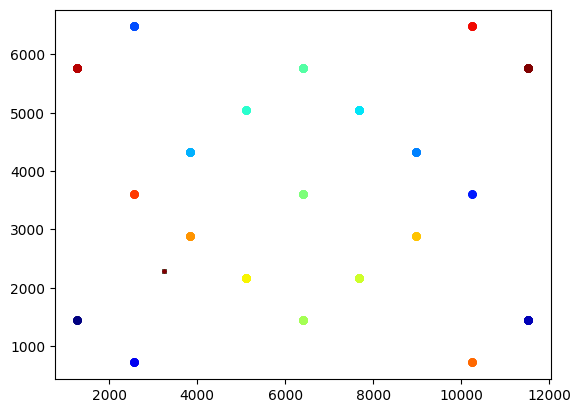

/DATAHDD/chailex/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


-0.7976107616862543
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.07218154]
[2.50078139 3.072181

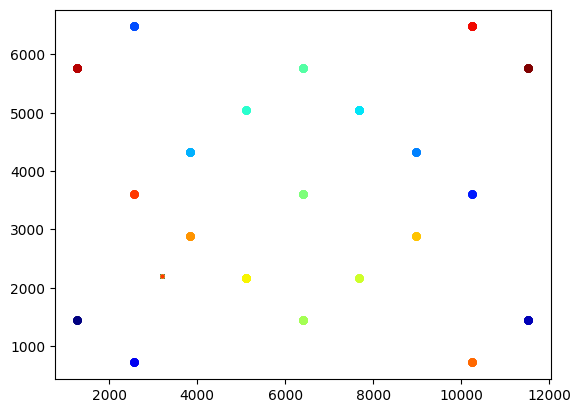

/DATAHDD/chailex/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


-0.7203520332374607
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.29182018]
[2.5684472  3.291820

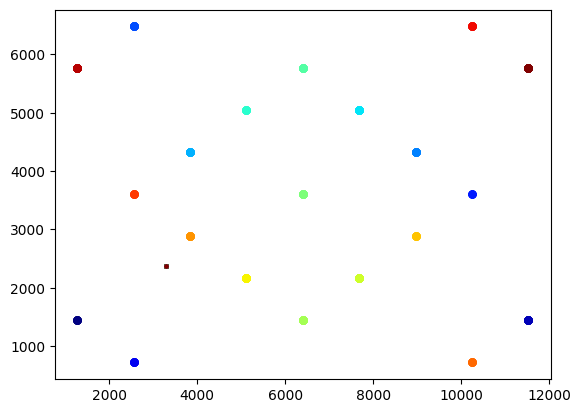

In [22]:
for dd in range(3):
    original_data = pd.read_csv("../participant_wise_data/participant_{}_data.csv".format(dd))
    data = list()
    for i in range(len(original_data)):
        temp = list()
        temp.append(original_data.iloc[i,0])
        temp.append(original_data.iloc[i,1])
        list_data = ast.literal_eval(original_data.iloc[i,2])
        temp.append(list_data)
        temp.append(ast.literal_eval(original_data.iloc[i,3]))
        data.append(temp)
    df = pd.DataFrame(data)
    X = df.iloc[:,2]
    y = df.iloc[:,3]

    time_series_data = X
    targets = y

    data = pd.DataFrame({'time_series_data': time_series_data, 'target': targets})

    X = np.array(data['time_series_data'].tolist())
    y = np.array(data['target'].tolist())
    
    xx = []
    yy = []
    for i in X:
        temp = []
        for j in range(len(i)):
            temp.append(i[j])
        xx.append(temp)
    # print(xx[0])

    for i in y:
        temp = []
        for j in range(len(i)):
            temp.append(i[j])
        yy.append(temp)
    # print(yy[0])

    X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.3, random_state=42)

    ##################################################################
    regr = MLP(hidden_layer_sizes=(512, 256, 128, 2),random_state=1, max_iter=1000).fit(X_train, y_train)
    pred = regr.predict(X_test)
    print(regr.score(X_test, y_test))
    # pred = regr.predict(X_test)
    # print(pred)
    for i in pred:
        print(i)
    print(regr.score(X_test, y_test))
    target_colors = plt.cm.jet(np.linspace(0, 1, 21))

    target = [[1,2],[1,8],[2,1],[2,5],[2,9],[3,4],[3,6],[4,3],[4,7],[5,2],[5,5],[5,8],[6,3],[6,7],[7,4],[7,6],[8,1],[8,5],[8,9],[9,2],[9,8]]
    color_list = {str([1,2]): target_colors[0],str([1,8]): target_colors[19],str([2,1]): target_colors[2],str([2,5]):target_colors[17],str([2,9]):target_colors[4],str([3,4]):target_colors[15],str([3,6]):target_colors[6],str([4,3]):target_colors[13],str([4,7]):target_colors[8],str([5,2]):target_colors[11],str([5,5]):target_colors[10],str([5,8]):target_colors[9],str([6,3]):target_colors[12],str([6,7]):target_colors[7],str([7,4]):target_colors[14],str([7,6]):target_colors[5],str([8,1]):target_colors[16],str([8,5]):target_colors[3],str([8,9]):target_colors[18],str([9,2]):target_colors[1],str([9,8]):target_colors[20]}

    image = cv2.imread('../../new_data_training/points.jpg')
    image_height, image_width, _ = image.shape
    # scaled_targets = [(int(x * image_width), int(y * image_height)) for x, y in target]

    scaled_predicted_points = [(int(x * image_width) if x>-1 else int(x * image_width)*-1, int(y * image_height) if y>-1 else int(y * image_height) *-1) for x, y in pred]
    scaled_target_points_color = [color_list[str([int(i[0]),int(i[1])])] for i in y_test]

    counter = 0
    for point in scaled_predicted_points:
        plt.scatter(point[0], point[1], color=scaled_target_points_color[counter], s=5, marker='o')  # Adjust marker size and color as needed
        counter += 1

    for point in y_test:
        plt.scatter(int(point[0] * image_width), int(point[1] * image_height), color=color_list[str(point)], s=25, marker='o')  # Adjust marker size and color as needed


    # Show the plot
    plt.show()